In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa

import PIL
from PIL import Image
import cv2
from sklearn.utils import class_weight, shuffle
import keras
import warnings
from keras.utils import Sequence
warnings.filterwarnings("ignore")
SIZE = 299
SEED = 777
THRESHOLD = 0.2

Using TensorFlow backend.


In [2]:
# Load dataset info
DIR = '../input/'
data = pd.read_csv('../input/train.csv')

# train_dataset_info = []
# for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
#     train_dataset_info.append({
#         'path':os.path.join(path_to_train, name),
#         'labels':np.array([int(label) for label in labels])})
# train_dataset_info = np.array(train_dataset_info)

In [3]:
def getTrainDataset():
    
    path_to_train = DIR + '/train/'
    data = pd.read_csv(DIR + '/train.csv')

    paths = []
    labels = []
    
    for name, lbl in zip(data['Id'], data['Target'].str.split(' ')):
        y = np.zeros(28)
        for key in lbl:
            y[int(key)] = 1
        paths.append(os.path.join(path_to_train, name))
        labels.append(y)

    return np.array(paths), np.array(labels)

def getTestDataset():
    
    path_to_test = DIR + '/test/'
    data = pd.read_csv(DIR + '/sample_submission.csv')

    paths = []
    labels = []
    
    for name in data['Id']:
        y = np.ones(28)
        paths.append(os.path.join(path_to_test, name))
        labels.append(y)

    return np.array(paths), np.array(labels)
paths, labels = getTrainDataset()

In [4]:
# credits: https://github.com/keras-team/keras/blob/master/keras/utils/data_utils.py#L302
# credits: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class ProteinDataGenerator(keras.utils.Sequence):
            
    def __init__(self, paths, labels, batch_size, shape, shuffle = False, channels = [""], use_cache = False):
        self.paths, self.labels = paths, labels
        self.batch_size = batch_size
        self.shape = shape
        self.shuffle = shuffle
        self.use_cache = use_cache
        if use_cache == True:
            self.cache = np.zeros((paths.shape[0], shape[0], shape[1], shape[2]))
            self.is_cached = np.zeros((paths.shape[0]))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx+1) * self.batch_size]

        paths = self.paths[indexes]
        X = np.zeros((paths.shape[0], self.shape[0], self.shape[1], self.shape[2]))
        # Generate data
        if self.use_cache == True:
            X = self.cache[indexes]
            for i, path in enumerate(paths[np.where(self.is_cached[indexes] == 0)]):
                image = self.__load_image(path)
                self.is_cached[indexes[i]] = 1
                self.cache[indexes[i]] = image
                X[i] = image
        else:
            for i, path in enumerate(paths):
                X[i] = self.__load_image(path)

        y = self.labels[indexes]
        
        return X, y
    
    def on_epoch_end(self):
        
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        for item in (self[i] for i in range(len(self))):
            item = self.augment(item)
            yield item
            
    def __load_image(self, path):
        R = Image.open(path + '_red.png')
        G = Image.open(path + '_green.png')
        B = Image.open(path + '_blue.png')
        Y = Image.open(path + '_yellow.png')

        im = np.stack((
            np.array(R), 
            np.array(G), 
            np.array(B),
            np.array(Y)
        ), -1)
        im = cv2.resize(im, (SIZE,SIZE))
        im = np.divide(im, 255)
        return im
    def augment(self, image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)

        image_aug = augment_img.augment_image(image)
        return image_aug

In [5]:
# # credits: https://github.com/keras-team/keras/blob/master/keras/utils/data_utils.py#L302
# # credits: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

# class ProteinDataGenerator(keras.utils.Sequence):
            
#     def __init__(self, paths, labels, batch_size, shape, channels, shuffle = False, use_cache = False):
#         self.paths, self.labels = paths, labels
#         self.batch_size = batch_size
#         self.shape = shape
#         self.shuffle = shuffle
#         self.use_cache = use_cache
#         self.channels = channels
#         if use_cache == True:
#             self.cache = np.zeros((paths.shape[0], shape[0], shape[1], len(channels)))
#             self.is_cached = np.zeros((paths.shape[0]))
#         self.on_epoch_end()
    
#     def __len__(self):
#         return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
#     def __getitem__(self, idx):
#         indexes = self.indexes[idx * self.batch_size : (idx+1) * self.batch_size]
#         paths = self.paths[indexes]
#         X = np.zeros((paths.shape[0], self.shape[0], self.shape[1], len(self.channels)))
#         # Generate data
#         if self.use_cache == True:
#             X = self.cache[indexes]
#             for i, path in enumerate(paths[np.where(self.is_cached[indexes] == 0)]):
#                 image = self.__load_image(path, self.channels)
#                 self.is_cached[indexes[i]] = 1
#                 self.cache[indexes[i]] = image
#                 X[i] = image
#         else:
#             for i, path in enumerate(paths):
#                 X[i] = self.__load_image(path, self.channels)

#         y = self.labels[indexes]
        
#         return X, y
    
#     def on_epoch_end(self):
        
#         # Updates indexes after each epoch
#         self.indexes = np.arange(len(self.paths))
#         if self.shuffle == True:
#             np.random.shuffle(self.indexes)

#     def __iter__(self):
#         """Create a generator that iterate over the Sequence."""
#         for item in (self[i] for i in range(len(self))):
#             item = self.augment(item)
#             yield item
            
#     def __load_image(self, path, channels = ["green", "red", "blue", "yellow"]):
#         images = []
#         for channel in channels:
#             images.append(np.array(Image.open(path + '_' + channel + '.png')))

#         if len(channels) >= 2:
#             im = np.stack((
#                 images
#             ), -1)
#         else:
#             im = images[0]
#         im = cv2.resize(im, (SIZE,SIZE))
#         im = np.divide(im, 255)
#         return im
#     def augment(self, image):
#         augment_img = iaa.Sequential([
#             iaa.OneOf([
#                 iaa.Affine(rotate=0),
#                 iaa.Affine(rotate=90),
#                 iaa.Affine(rotate=180),
#                 iaa.Affine(rotate=270),
#                 iaa.Fliplr(0.5),
#                 iaa.Flipud(0.5),
#             ])], random_order=True)
#         image_aug = augment_img.augment_image(image)
#         return image_aug

In [6]:
path = paths[0]

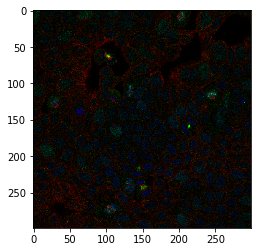

In [7]:
images = []
channels = ["red", "green", "blue"]
for channel in channels:
    images.append(np.array(Image.open(path + '_' + channel + '.png')))
if len(channels) >= 2:
    im = np.stack((
        images
    ), -1)
else:
    im = images[0]
im = cv2.resize(im, (SIZE,SIZE))
im = np.divide(im, 255)
plt.imshow(im)

In [8]:
# class data_generator:
    
#     def create_train(dataset_info, batch_size, shape, augument=True):
#         assert shape[2] == 3
#         while True:
#             dataset_info = shuffle(dataset_info)
#             for start in range(0, len(dataset_info), batch_size):
#                 end = min(start + batch_size, len(dataset_info))
#                 batch_images = []
#                 X_train_batch = dataset_info[start:end]
#                 batch_labels = np.zeros((len(X_train_batch), 28))
#                 for i in range(len(X_train_batch)):
#                     image = data_generator.load_image(
#                         X_train_batch[i]['path'], shape)   
#                     if augument:
#                         image = data_generator.augment(image)
#                     batch_images.append(image/255.)
#                     batch_labels[i][X_train_batch[i]['labels']] = 1
#                 yield np.array(batch_images, np.float32), batch_labels

#     def load_image(path, shape):
#         image_red_ch = Image.open(path+'_red.png')
#         image_yellow_ch = Image.open(path+'_yellow.png')
#         image_green_ch = Image.open(path+'_green.png')
#         image_blue_ch = Image.open(path+'_blue.png')
#         image = np.stack((
#         np.array(image_red_ch), 
#         np.array(image_green_ch), 
#         np.array(image_blue_ch)), -1)
#         image = cv2.resize(image, (shape[0], shape[1]))
#         return image

#     def augment(image):
#         augment_img = iaa.Sequential([
#             iaa.OneOf([
#                 iaa.Affine(rotate=0),
#                 iaa.Affine(rotate=90),
#                 iaa.Affine(rotate=180),
#                 iaa.Affine(rotate=270),
#                 iaa.Fliplr(0.5),
#                 iaa.Flipud(0.5),
#             ])], random_order=True)

#         image_aug = augment_img.augment_image(image)
#         return image_aug

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, BatchNormalization, Input, Conv2D, MaxPooling2D
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model
from keras.utils import multi_gpu_model

In [10]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)

    base_model = InceptionV3(include_top=False,
                   weights='imagenet',
                   input_shape=(299,299,3)
                            )
    bn = BatchNormalization()(input_tensor)
    if input_shape[2] == 4:
        x = Conv2D(3, kernel_size=(1,1), activation='relu', padding = "same")(bn)
        x = base_model(x)
    else:
        x = base_model(input_tensor)
    x = Conv2D(32, kernel_size=(3,3), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_out, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    
    return model

In [11]:
def f1(y_true, y_pred):
    #y_pred = K.round(y_pred)
    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [12]:
# create callbacks list
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

epochs = 10;
batch_size = 16;
VAL_RATIO = .1;
DEBUG = False;
# split data into train, valid
paths, labels = getTrainDataset()

# divide to 
keys = np.arange(paths.shape[0], dtype=np.int)  
np.random.seed(SEED)
np.random.shuffle(keys)
lastTrainIndex = int((1-VAL_RATIO) * paths.shape[0])

if DEBUG == True:  # use only small subset for debugging, Kaggle's RAM is limited
    pathsTrain = paths[0:256]
    labelsTrain = labels[0:256]
    pathsVal = paths[lastTrainIndex:lastTrainIndex+256]
    labelsVal = labels[lastTrainIndex:lastTrainIndex+256]
    use_cache = True
else:
    pathsTrain = paths[0:lastTrainIndex]
    labelsTrain = labels[0:lastTrainIndex]
    pathsVal = paths[lastTrainIndex:]
    labelsVal = labels[lastTrainIndex:]
    use_cache = False

print(paths.shape, labels.shape)
print(pathsTrain.shape, labelsTrain.shape, pathsVal.shape, labelsVal.shape)
use_cache = True
channels = ["red", "blue", "green", "yellow"]
# channels = ["red", "blue", "green"]
SHAPE = (SIZE, SIZE, len(channels))
tg = ProteinDataGenerator(pathsTrain, labelsTrain, batch_size, SHAPE, channels, use_cache=use_cache)
vg = ProteinDataGenerator(pathsVal, labelsVal, batch_size, SHAPE, channels, use_cache=use_cache)

(31072,) (31072, 28)
(27964,) (27964, 28) (3108,) (3108, 28)


In [13]:
# next(tg.__iter__()).shape
# create train and valid datagens
# train_generator = data_generator.create_train(
#     train_dataset_info[train_indexes], batch_size, (SIZE,SIZE,3), augument=True)
# validation_generator = data_generator.create_train(
#     train_dataset_info[valid_indexes], 32, (SIZE,SIZE,3), augument=False)

In [14]:
checkpoint = ModelCheckpoint('../working/InceptionV3_focal.h5', monitor='val_f1', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = False)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_f1', factor=0.1, patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001)
early = EarlyStopping(monitor="val_f1", 
                      mode="max", 
                      patience=6)
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [15]:
'''
Compatible with tensorflow backend
'''
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [16]:
# warm up model
import tensorflow as tf
# with tf.device('/cpu:0'):
model = create_model(
    input_shape=(SIZE, SIZE, len(channels)), 
    n_out=28)

for layer in model.layers:
    layer.trainable = False
if len(channels) == 4:
    model.layers[2].trainable = True
model.layers[-1].trainable = True
model.layers[-2].trainable = True
model.layers[-3].trainable = True
model.layers[-4].trainable = True
model.layers[-5].trainable = True
model.layers[-6].trainable = True

model.summary()
# model = multi_gpu_model(model, gpus = 2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 4)       0         
_________________________________________________________________
batch_normalization_95 (Batc (None, 299, 299, 4)       16        
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 299, 299, 3)       15        
_________________________________________________________________
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 6, 6, 32)          589856    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1152)              0         
__________

In [17]:
model.compile(
    loss="binary_crossentropy", 
    optimizer=Adam(1e-03),
    metrics=['acc', f1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 4)       0         
_________________________________________________________________
batch_normalization_95 (Batc (None, 299, 299, 4)       16        
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 299, 299, 3)       15        
_________________________________________________________________
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 6, 6, 32)          589856    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1152)              0         
__________

In [18]:
tg = ProteinDataGenerator(pathsTrain, labelsTrain, batch_size, (299,299,4), channels, use_cache=use_cache)
vg = ProteinDataGenerator(pathsVal, labelsVal, batch_size, (299,299,4), channels, use_cache=use_cache)

In [19]:
model.fit_generator(
    tg,
    steps_per_epoch=np.ceil(float(len(pathsTrain)) / float(batch_size)),
    validation_data=vg,
    validation_steps=np.ceil(float(len(pathsVal)) / float(batch_size)),
    epochs=5, 
    verbose=1,
    callbacks=callbacks_list)

Epoch 1/5
1748/1748 [==============================] - 898s 514ms/step - loss: 0.1829 - acc: 0.9408 - f1: 0.0481 - val_loss: 0.1762 - val_acc: 0.9413 - val_f1: 0.0357

Epoch 00001: val_f1 improved from -inf to 0.03573, saving model to ../working/InceptionV3_focal.h5
Epoch 2/5
 150/1748 [=>............................] - ETA: 4:40 - loss: 0.1737 - acc: 0.9429 - f1: 0.0471

KeyboardInterrupt: 

In [ ]:
# model1 = model.layers[-2]

In [ ]:
# train all layers

for layer in model.layers:
    print(layer)
    layer.trainable = True
# model1 = multi_gpu_model(model1, gpus = 2)
model.compile(loss="binary_crossentropy",
            optimizer=Adam(lr=1e-4),
            metrics=['accuracy', f1])

In [ ]:
model.fit_generator(
    tg,
    steps_per_epoch=np.ceil(float(len(pathsTrain)) / float(batch_size)),
    validation_data=vg,
    validation_steps=np.ceil(float(len(pathsVal)) / float(batch_size)),
    epochs=50, 
    verbose=1,
    callbacks=callbacks_list)
    

In [25]:
from keras.models import load_model
# bestModel = load_model('../working/InceptionV3.h5')

In [26]:
#fullValGen = ProteinDataGenerator(paths[lastTrainIndex:], labels[lastTrainIndex:], BATCH_SIZE, SHAPE)
#fullValPred = np.zeros((paths[lastTrainIndex:].shape[0], 28))
#for i in tqdm(range(len(fullValGen))):
bestModel = model

In [27]:
from tqdm import tqdm
pathsTest, labelsTest = getTestDataset()

testg = ProteinDataGenerator(pathsTest, labelsTest, batch_size, SHAPE)
submit = pd.read_csv(DIR + '/sample_submission.csv')
P = np.zeros((pathsTest.shape[0], 28))
for i in tqdm(range(len(testg))):
    images, labels = testg[i]
    score = bestModel.predict(images)
    P[i*batch_size:i*batch_size+score.shape[0]] = score

100%|████████████████████████████████████████████████████████████████████████████████| 732/732 [04:58<00:00,  2.45it/s]


In [28]:
PP = np.array(P)

In [29]:
prediction = []

for row in tqdm(range(submit.shape[0])):
    
    str_label = ''
    
    for col in range(PP.shape[1]):
        if(PP[row, col] < .2):   # to account for losing TP is more costly than decreasing FP
            #print(PP[row])
            str_label += ''
        else:
            str_label += str(col) + ' '
    prediction.append(str_label.strip())
    
submit['Predicted'] = np.array(prediction)
submit.to_csv('datagenerator_model_only_focal_loss.csv', index=False)

100%|█████████████████████████████████████████████████████████████████████████| 11702/11702 [00:00<00:00, 57390.18it/s]
